# Satellite Trail Masking Techniques

<div class="alert-danger">Note: The notebook in this repository 'Initializtion.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

Even though Hubble has a small field of view, satellites are commonly captured in images. The cosmic ray rejection algorithm in Astrodrizzle is not well suited to eliminate satellite trails, and the affected adjacent pixels that make up their wings leave ugly blemishes in stacked images. 

To fix this problem, the pixels around satellite trails need to be marked as bad in the affected images. There are several ways to do this. The ACS Team has developed an algorithm to automatically detect and mask satellite trails. This is the easiest and most convenient way. Masks can also be made manually using DS9 regions. While not as convenient, making masks manually allows you to mask not only satellites, but also any other anomalies with odd shapes (e.g. dragon's breath, glint, blooming). 

Both methods are explained below. 

In [1]:
import os
import shutil

from astropy.io import fits
from astroquery.mast import Observations
from astropy.visualization import astropy_mpl_style,LogStretch,ImageNormalize,LinearStretch
from IPython.display import Image
import matplotlib.pyplot as plt
import pyregion

import acstools
from acstools.findsat_mrt import WfcWrapper
from acstools.utils_findsat_mrt import update_dq
from acstools.satdet import detsat, make_mask
from astropy.nddata import block_replicate
from drizzlepac.astrodrizzle import AstroDrizzle as adriz

%matplotlib inline



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Dowload the Data

The images to be used are the F814W images of visit B7 from GO program [13498](http://www.stsci.edu/cgi-bin/get-proposal-info?id=13498&observatory=HST). These come from the Hubble Frontier Fields program and are images of the the galaxy cluster MACSJ0717.5+3745. 

There are four dithered exposures in the association to be downloaded.

In [12]:
#Searching for the observsation
results = Observations.query_criteria(obs_id='JC8MB7020', obstype='all')

#Downloading previews and FLC files
jpg_download = Observations.download_products(results['obsid'], mrp_only=False, extension=['jpg'])
flc_download = Observations.download_products(results['obsid'], productSubGroupDescription=['FLC'], mrp_only=False)

  warnings.warn("Filter {} does not exist. This filter will be skipped.".format(colname), InputWarning)



In [13]:
# Cleaning up directories after downloading from MAST
for file in jpg_download['Local Path']:
    if 'drc' in file:
        os.rename(file, os.path.basename(file))
        
for file in flc_download['Local Path']:
       os.rename(file, os.path.basename(file))
        
shutil.rmtree('mastDownload')

The image below shows the combined drizzled image from this association. The satellite trail can be seen going across the image from left to right, just above the center of the image. 

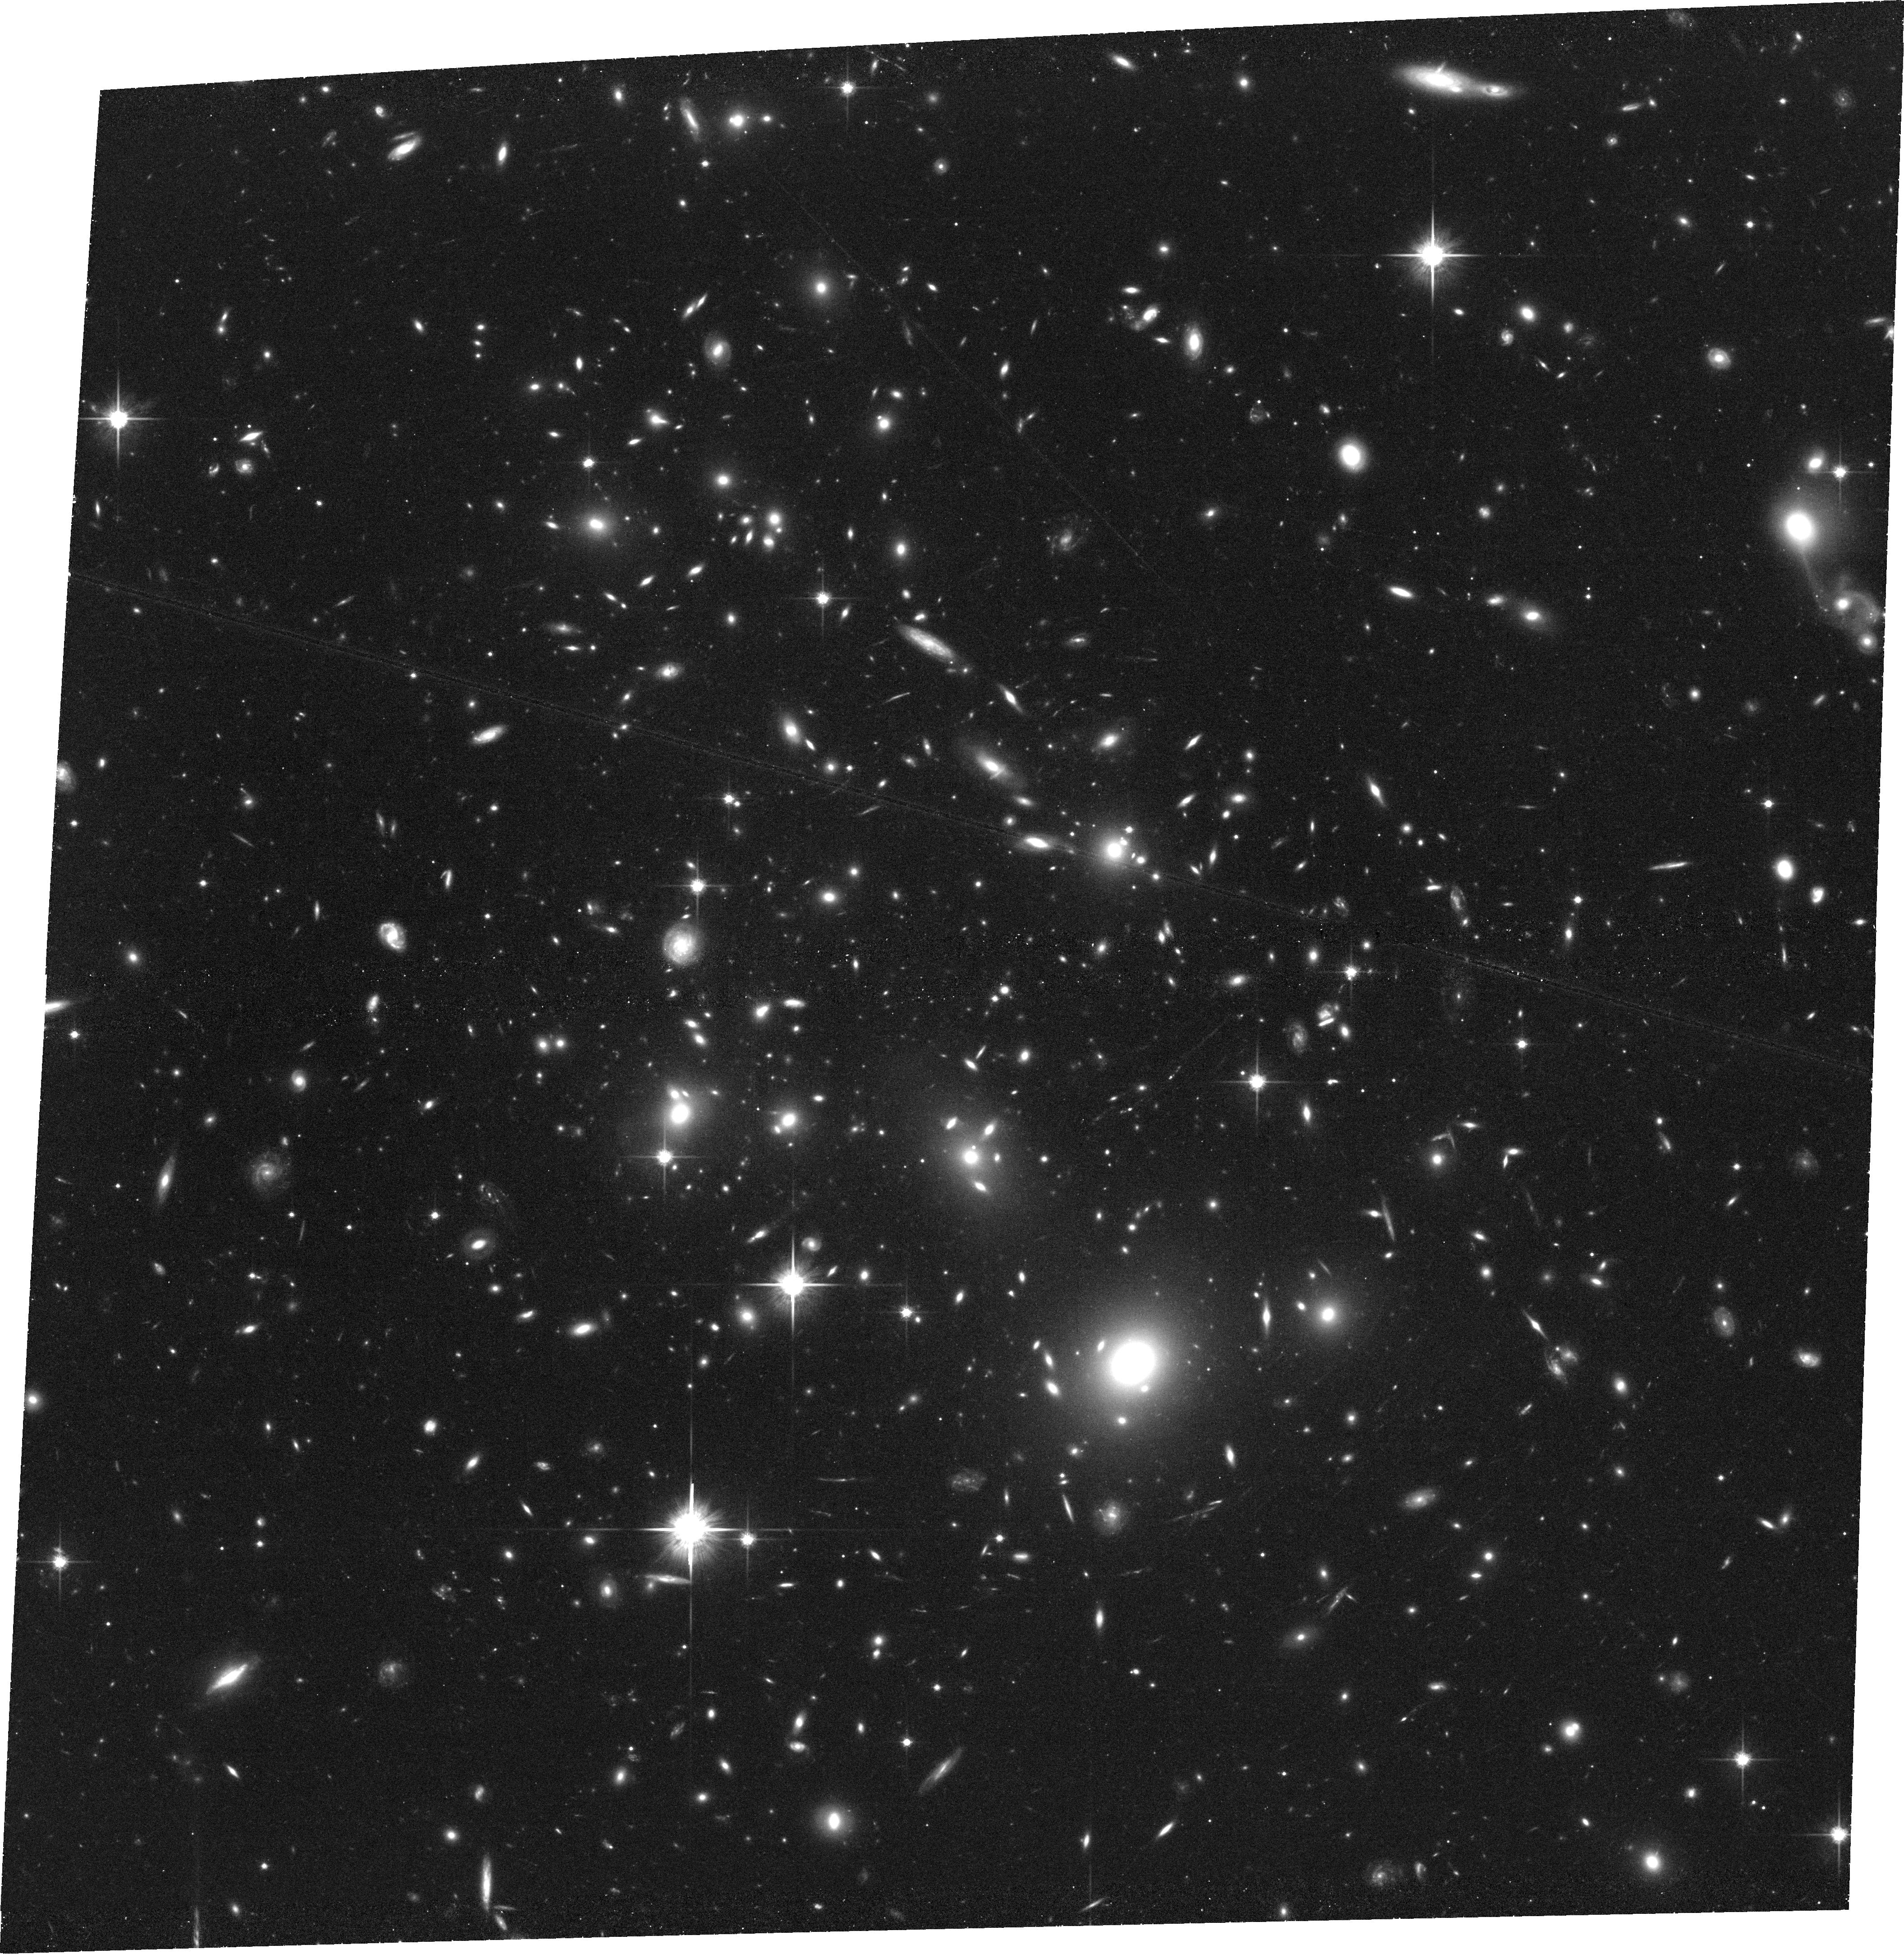

In [2]:
Image(filename='jc8mb7020_drc.jpg')

The bright satellite trail that caused this came from the image *jc8mb7cq_flc.fits*. The figure below shows the top chip which is referred to as SCI,2 (or extension 4). 

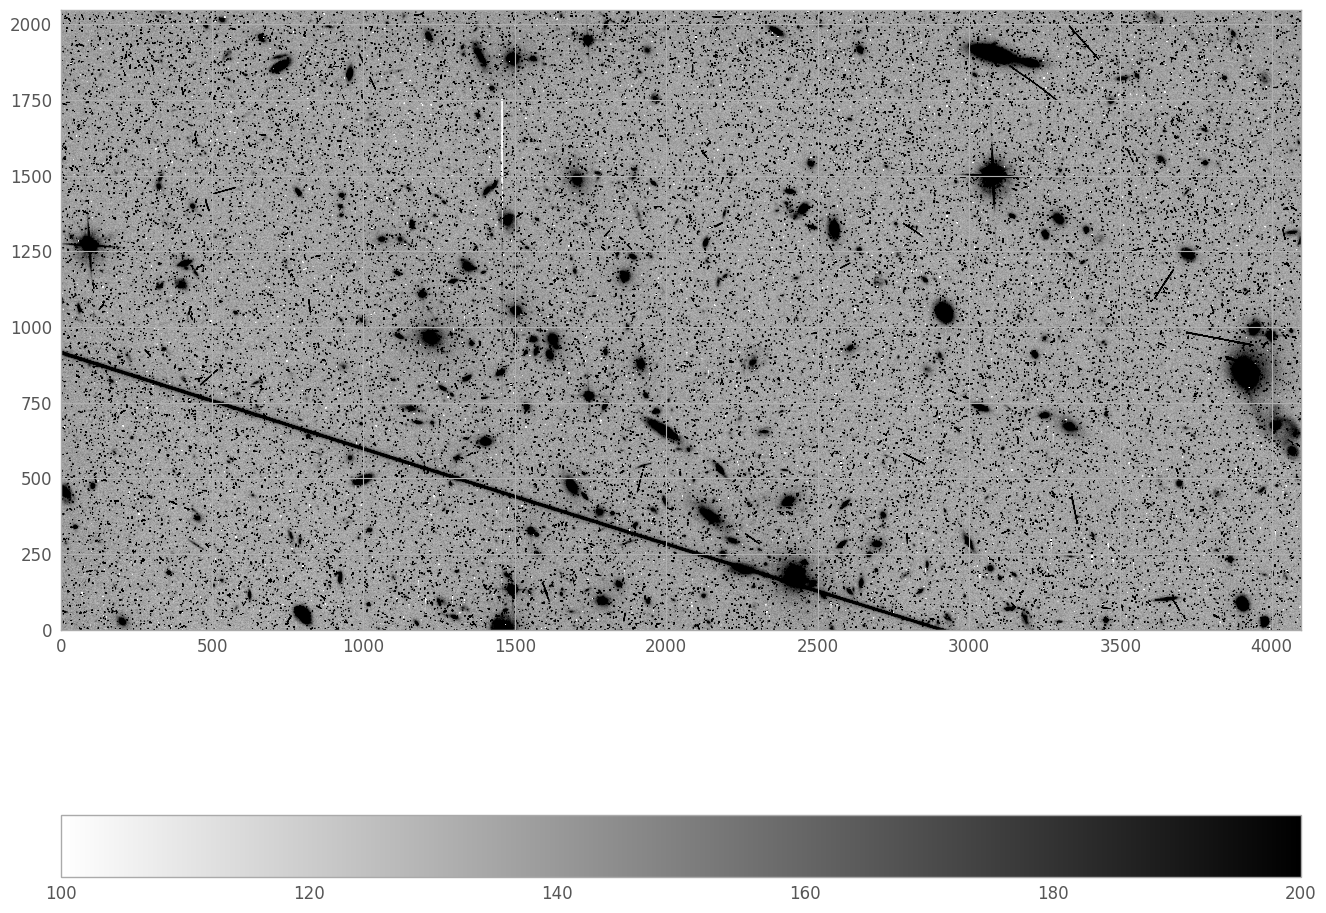

In [3]:
plt.style.use(astropy_mpl_style)
img = fits.getdata('jc8mb7tcq_flc.fits', ext=4)

norm1 = ImageNormalize(img, vmin=100, vmax=200, stretch=LinearStretch())
plt.figure(figsize=(16, 16))
plt.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(orientation='horizontal')

## 2. Automated tools for masking satellites

The ACS Team developed multiple algorithms to automatically detect and mask satellite trails. The newest is a module called `findsat_mrt` and is decribed in [ISR ACS 2022-08](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf). The 'readthedocs' page can be found here: [MRT-based Satellite Trail Detection](https://acstools.readthedocs.io/en/latest/findsat_mrt.html). The second module is called `satdet` and is described in [ISR ACS 2016-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1601.pdf).  The 'readthedocs' page for the software can be found here: [Satellite Trails Detection](https://acstools.readthedocs.io/en/stable/satdet.html). `findsat_mrt` has significantly improved sensitivity over `satdet` but is more computationally demanding. We demonstrate both approaches below.

### 2a. Using findsat_mrt

The `WfcWrapper` class provides a simple one-line approach to creating a mask for satellite trails. In this example, we run `WfcWrapper` on the top chip only (SCI,1 or extension 4). `WfcWrapper` loads the data, prepares the image (applies rebinning, removes a background, and masks already identified bad pixels), and executes the detection routines. In this example, we rebin the data by 2 pixels in each direction and use 8 processes. You may want to adjust the binning and/or number of processes depending on your system. We also set a maximum trail width of 75 pixels (this can also be adjusted depending on your binning).

In [4]:
w = WfcWrapper('jc8mb7tcq_flc.fits', 
               extension=4, 
               binsize=2, 
               processes=8, 
               max_width=75,
               preprocess=True, 
               execute=True)

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2
INFO:findsat_mrt:Running the trailfinding pipeline
INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/stenv/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 3
INFO:findsat_mrt:3 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/stenv/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /Users/dstark/miniconda3/envs/stenv/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 9
INFO:findsat_mrt:9 so

INFO:utils_findsat_mrt:width of feature = 67.43412057663784
INFO:utils_findsat_mrt:amplitude of feature: 7.926641932802028
baseline noise: 1.305613357163298
snr of feature = 5.071201622832825
INFO:utils_findsat_mrt:width of feature = 154.42759438733555
INFO:findsat_mrt:Wrote diagnostic plot to ./_diagnostic.png
INFO:findsat_mrt:wrote catalog ./_catalog.fits


We can plot the mask on its own, or overlaid on the input image. 

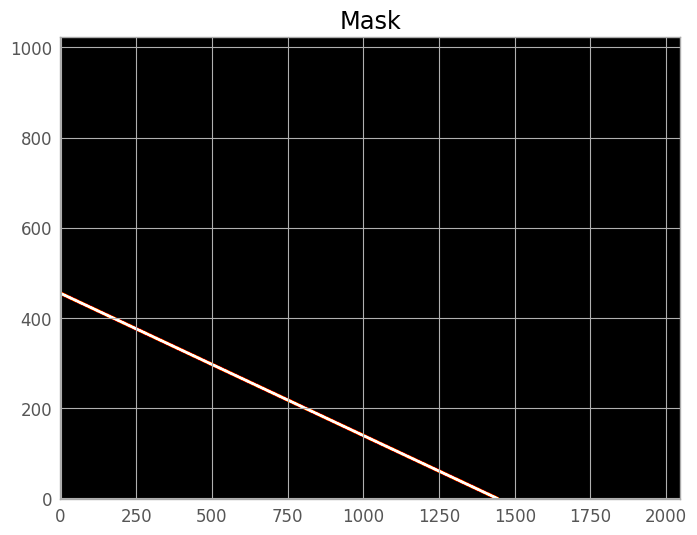

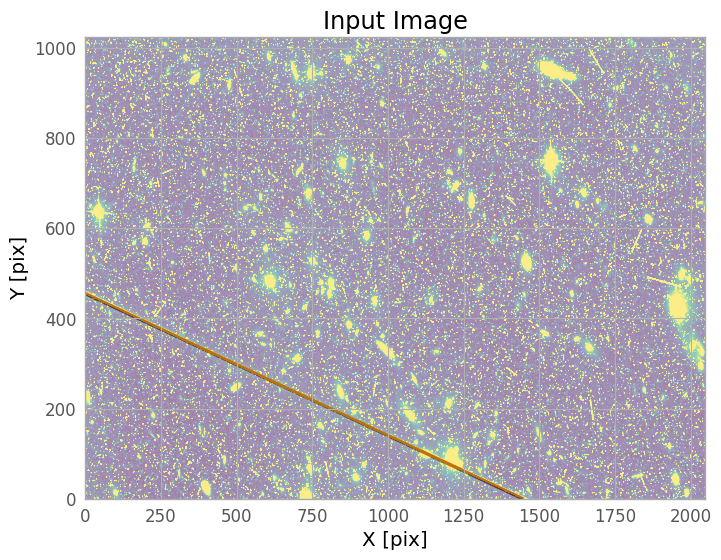

In [5]:
w.plot_mask()
w.plot_image(overlay_mask=True)

The routine `update_dq` can be used to include the satellite mask in the data quality (DQ) array for this image. Note that the mask has the dimensions of the rebinned image, so you will need to first expand the mask to the original dimensions. This can be easily accomplished using the `astropy.nddata.block_replicate` routine.

In [6]:
w.mask = block_replicate(w.mask, 2, conserve_sum=False)
w.update_dq()

DQ flag value is 16384
Input... flagged NPIX=48492
Existing flagged NPIX=48492
Newly... flagged NPIX=0
No updates necessary for jc8mb7tcq_flc.fits[6]


### 2b. Using satdet

The first command below runs the detection algorithm on the top chip only (extension 4) and generates some diagnostic plots. Note that the images are shown upside down from the figure above. 

In [17]:
results, errors = detsat('jc8mb7tcq_flc.fits',
                         chips=[4],
                         n_processes=4,
                         plot=True,
                         verbose=True)

1 file(s) found...

Processing jc8mb7tcq_flc.fits[4]...
Rescale intensity percentiles: 112.31252529144287, 173.1698686218262
<class 'TypeError'>: TypeError("remove_small_objects() got an unexpected keyword argument 'in_place'")

Total run time: 1.205199956893921 s


In [15]:
results

{}

The diagnostic plots can be used to verify that the satellite was properly detected. Changing parameters to adjust this task is beyond the scope of this notebook, but please consult the package documentation indicated above for instructions on how to do this. 

Assuming that the satellite trail was properly detected, masks can be made to flag the satellite in the data quality array (DQ) of the image. Once this information is in the DQ array, AstroDrizzle knows to ignore the flagged pixels when making the combined image.  The function `update_dq` is used to flag pixels in the DQ array of SCI,2 (extension 6) using the default flag value of 16384. 

If the satellite were instead on the bottom chip (SCI,1 or extension 1), the `update_dq` function would instead be used to modify extension 3. More detail on the ACS file structure may be found in the [ACS Data Handbook](http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch23.html).

In [10]:
trail_coords = results[('jc8mb7tcq_flc.fits', 4)]
trail_segment = trail_coords[0]
trail_segment
mask = make_mask('jc8mb7tcq_flc.fits', 4, trail_segment, plot=True, verbose=True)
update_dq('jc8mb7tcq_flc.fits', 6, mask, verbose=True)

KeyError: ('jc8mb7tcq_flc.fits', 4)

With the satellite masked, the images can be drizzled again. For brevity, only the top chip (SCI,2) of the image stack will be drizzled together to make a combined product. This is controlled in `AstroDrizzle` via the `group` parameter.

In [ ]:
adriz('*flc.fits',
      output='automatic',
      runfile='',
      context=False,
      group='4',
      build=True,
      num_cores=1,
      preserve=False,
      clean=True,
      driz_sep_bits='64,16',
      final_bits='64,16')

The final drizzled product shows that the bright satellite trail and its wings have been removed. A second, fainter satellite can be seen from a different image in the stack, and this will be masked in the steps below. 

In [ ]:
img = fits.getdata('automatic_drc.fits', ext=1)

norm1 = ImageNormalize(img, vmin=-0.01, vmax=0.02, stretch=LinearStretch())
plt.figure(figsize=(20, 20))
plt.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(orientation='horizontal')

## 3. Manual masking of satellites and other anomalies

While the automatic detection algorithm flagged and masked the large satellite trail, the image above shows a second trail from a different image in the stack. 

To get rid of this trail, we will demonstrate how a DS9 regions can be used. The example image displayed below shows a region around a satellite trail. 

This region was saved in image coordinates. **NOTE THAT REGIONS SAVED IN SKY COORDINATES WILL NOT WORK FOR THIS EXAMPLE**. Below is the contents of the region file.

```
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(1476.9255,1816.4415,1545.7465,1818.5921,2825.3869,485.1853,2765.1685,480.88399)
```

The `pyregion` package will be used to make masks out of region files. For details on how to use this package go [here](https://pyregion.readthedocs.io/en/latest/). (*This package will eventually be superseded by the astropy affiliated `regions` package*.)

In [ ]:
Image(filename='sat.jpeg')

In [ ]:
# Reading region file
reg_file = pyregion.parse('''# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
image
polygon(1476.9255,1816.4415,1545.7465,1818.5921,2825.3869,485.1853,2765.1685,480.88399)''')

# Making mask out of region file and masking DQ array
with fits.open('jc8mb7t5q_flc.fits', mode='update') as hdu:

    dq  = hdu[6].data
    mask = reg_file.get_mask(shape=dq.shape)
    dq[mask] |= 16384      
        
norm1 = ImageNormalize(img, vmin=0, vmax=1000, stretch=LinearStretch())
plt.figure(figsize=(16, 10))
plt.imshow(dq, norm=norm1, cmap='gray_r', origin='lower')
plt.title('DQ array of jc8mb7t5q_flc.fits[6] showing masked pixels', fontsize=20)

With the satellite masked, the full set of images can be drizzled once more. 

In [ ]:
adriz('*flc.fits',
      output='manual',
      runfile='',
      context=False,
      group='4',
      build=True,
      num_cores=1,
      preserve=False,
      clean=True,
      driz_sep_bits='16, 64',
      final_bits='16, 64')

The new drizzled product shows that the second satellite trail and its wings have been removed.

In [ ]:
img = fits.getdata('manual_drc.fits', ext=1)

norm1 = ImageNormalize(img, vmin=-0.01, vmax=0.02, stretch=LinearStretch())
plt.figure(figsize=(20, 20))
plt.imshow(img, norm=norm1, cmap='gray_r', origin='lower')
plt.colorbar(orientation='horizontal')

## About this Notebook

    Author: R. Avila, STScI ACS Team  
    Updated: May 17, 2018